In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider
provider = SaverProvider()

In [3]:
from soft_info import get_counts, get_KDEs

# Code params
d = 3
T = 3
layout = [25, 19, 26, 22, 16] # Hardcoded for testing purposes, can be retrieved


job = provider.retrieve_job("cmyhbrqrmwhg008bs4h0")
memory = job.result().get_memory()

kde_dict, scaler_dict = get_KDEs(provider, 'ibmq_mumbai', layout, bandwidths=0.2, plot=False)
counts_kde = get_counts(memory, kde_dict, scaler_dict, layout, T, True)

Processing 1000 shots: 100%|██████████| 1000/1000 [00:55<00:00, 18.11it/s]


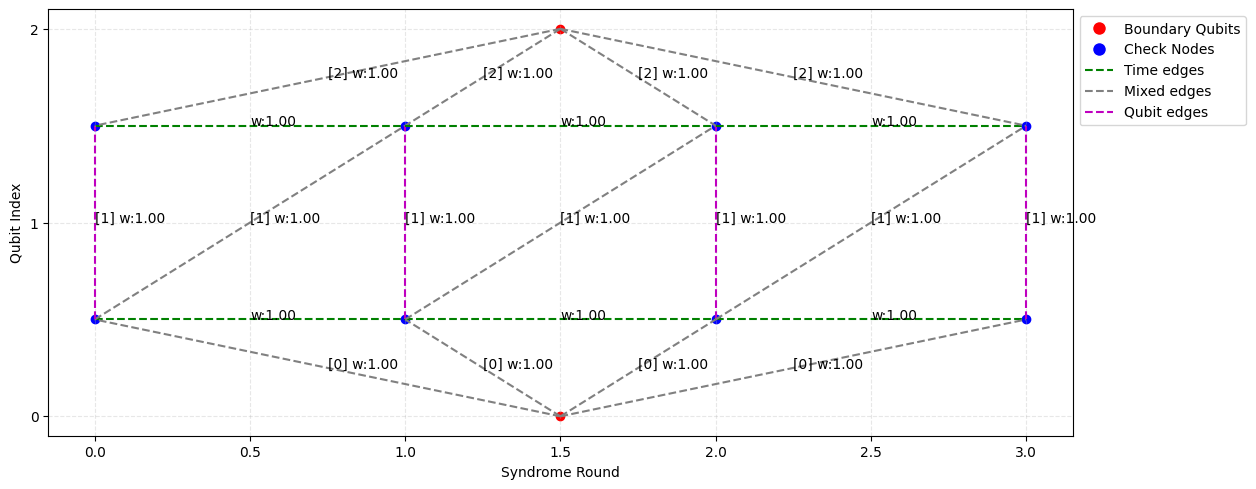

┌───┐     ┌───┐     ┌─┐   ┌───┐     ┌───┐     ┌─┐   ┌───┐     ┌───┐        ┌─┐         
      link_qubit_0: ┤ X ├─────┤ X ├─────┤M├───┤ X ├─────┤ X ├─────┤M├───┤ X ├─────┤ X ├────────┤M├─────────
                    └─┬─┘┌───┐└─┬─┘┌───┐└╥┘┌─┐└─┬─┘┌───┐└─┬─┘┌───┐└╥┘┌─┐└─┬─┘┌───┐└─┬─┘┌───┐   └╥┘┌─┐      
      link_qubit_1: ──┼──┤ X ├──┼──┤ X ├─╫─┤M├──┼──┤ X ├──┼──┤ X ├─╫─┤M├──┼──┤ X ├──┼──┤ X ├────╫─┤M├──────
                      │  └─┬─┘  │  └─┬─┘ ║ └╥┘  │  └─┬─┘  │  └─┬─┘ ║ └╥┘  │  └─┬─┘  │  └─┬─┘┌─┐ ║ └╥┘      
      code_qubit_0: ──■────┼────┼────┼───╫──╫───■────┼────┼────┼───╫──╫───■────┼────┼────┼──┤M├─╫──╫───────
                           │    │    │   ║  ║        │    │    │   ║  ║        │    │    │  └╥┘ ║  ║ ┌─┐   
      code_qubit_1: ───────■────■────┼───╫──╫────────■────■────┼───╫──╫────────■────■────┼───╫──╫──╫─┤M├───
                                     │   ║  ║                  │   ║  ║                  │   ║  ║  ║ └╥┘┌─┐
      code_qubit_2: ─────────────────■───╫──╫──────────────────■───╫──╫──────────────────■───╫──╫──╫──╫─┤M├
                                         ║  ║                      ║  ║                      ║  ║  ║  ║ └╥┘
round_0_link_bit: 2/═════════════════════╩══╩══════════════════════╬══╬══════════════════════╬══╬══╬══╬══╬═
                                         0  1                      ║  ║                      ║  ║  ║  ║  ║ 
round_1_link_bit: 2/═══════════════════════════════════════════════╩══╩══════════════════════╬══╬══╬══╬══╬═
                                                                   0  1                      ║  ║  ║  ║  ║ 
round_2_link_bit: 2/═════════════════════════════════════════════════════════════════════════╬══╩══╩══╬══╬═
                                                                                             ║  0  1  ║  ║ 
        code_bit: 3/═════════════════════════════════════════════════════════════════════════╩════════╩══╩═
                                                                                             0        1  2

In [5]:
from qiskit_qec.circuits import RepetitionCodeCircuit, ArcCircuit
from qiskit_qec.decoders import UnionFindDecoder
from soft_info import rx_draw_2D

code = RepetitionCodeCircuit(d, T)
decoder = UnionFindDecoder(code)
rx_draw_2D(decoder.graph)
code.circuit['0'].draw(fold=-1)

In [7]:
from soft_info import soft_reweight, get_counts
from tqdm import tqdm

logical_counts = {'0':0, '1':0}
for shot in (range(len(memory))[:400]):    
    IQ_data = memory[shot]

    counts = get_counts([IQ_data], kde_dict, scaler_dict, layout, T, verbose=False)
    count_key = next(iter(counts.keys()))
    
    if count_key == '000 00 00 00':
        continue
    print("------------- NEXT Faulty SHOT -------------")

    reweighted_graph = soft_reweight(decoder, IQ_data, kde_dict, scaler_dict, layout)
    decoder.graph = reweighted_graph

    logical, flipped_qubit_dict = decoder.process(count_key, _return_err_str = True)
    print("\nmeas_str:", count_key)
    print("flipped_qubit_dict", flipped_qubit_dict)
    print("logical:", logical, "\n")
    if logical[0] == 1:
        print("------------ Wrong logical! ------------\n")

    logical_counts[f"{logical[0]}"] += 1

print( "\nLogical_counts:", logical_counts)


------------- NEXT Faulty SHOT -------------
net_z_logicals BEFORE:  {(0,): 0}
Cluster 0 nodes:  [1, 7]
Cluster 1 nodes:  [8, 6]
net_z_logicals AFTER:  {(0,): 0}

meas_str: 010 11 01 00
flipped_qubit_dict {'Cluster_0': [1], 'Cluster_1': []}
logical: [0] 

------------- NEXT Faulty SHOT -------------
net_z_logicals BEFORE:  {(0,): 0}
Cluster 0 nodes:  [8, 9]
net_z_logicals AFTER:  {(0,): 0}

meas_str: 010 00 00 00
flipped_qubit_dict {'Cluster_0': [1]}
logical: [0] 

------------- NEXT Faulty SHOT -------------
net_z_logicals BEFORE:  {(0,): 0}
Cluster 0 nodes:  [0, 3]
net_z_logicals AFTER:  {(0,): 0}

meas_str: 010 11 00 11
flipped_qubit_dict {'Cluster_0': [1]}
logical: [0] 

------------- NEXT Faulty SHOT -------------
net_z_logicals BEFORE:  {(0,): 0}
Cluster 0 nodes:  [0, 3]
net_z_logicals AFTER:  {(0,): 0}

meas_str: 010 11 00 11
flipped_qubit_dict {'Cluster_0': [1]}
logical: [0] 

------------- NEXT Faulty SHOT -------------
net_z_logicals BEFORE:  {(0,): 0}
Cluster 0 nodes:  [0, 1

In [51]:
from soft_info import soft_reweight, get_counts
from tqdm import tqdm

logical_counts = {'0':0, '1':0}
for shot in tqdm(range(len(memory))[:1000]):    
    IQ_data = memory[shot]

    counts = get_counts([IQ_data], kde_dict, scaler_dict, layout, T, verbose=False)
    count_key = next(iter(counts.keys()))
    
    #if count_key[:3] in ["100", "001"]:
        #continue
    
    reweighted_graph = soft_reweight(decoder, IQ_data, kde_dict, scaler_dict, layout)
    decoder.graph = reweighted_graph

    logical, flipped_qubit_dict = decoder.process(count_key, _return_err_str = True)
    if logical[0] == 1:
        print("meas_str:", count_key)
        print("flipped_qubit_dict", flipped_qubit_dict)
    logical_counts[f"{logical[0]}"] += 1

print( "\nLogical_counts:", logical_counts)


 40%|████      | 404/1000 [00:52<01:10,  8.47it/s]

meas_str: 000 10 11 10
flipped_qubit_dict {'Cluster_0': [1, 2], 'Cluster_1': [0]}


 53%|█████▎    | 526/1000 [01:08<00:53,  8.81it/s]

meas_str: 001 01 10 00
flipped_qubit_dict {'Cluster_0': [2], 'Cluster_1': [1]}


 76%|███████▌  | 756/1000 [01:39<00:27,  8.89it/s]

meas_str: 010 10 00 00
flipped_qubit_dict {'Cluster_0': [2], 'Cluster_1': [0]}


100%|██████████| 1000/1000 [02:10<00:00,  7.65it/s]


Logical_counts: {'0': 997, '1': 3}


In [28]:
count_key = "001 01 10 00"

logical, flipped_qubit_dict = decoder.process(count_key, _return_err_str = True)
print("\nmeas_str:", count_key)
print("logical:", logical, "\n")
print("flipped_qubit_dict", flipped_qubit_dict)

net_z_logicals BEFORE:  {(0,): 0}
Cluster 0 nodes:  [4, 5, 7]
Cluster 1 nodes:  [9, 6]
net_z_logicals AFTER:  {(0,): 0}

meas_str: 001 01 10 00
logical: [0] 

flipped_qubit_dict {'Cluster_0': [2], 'Cluster_1': [1]}


# Comparing with counts job

In [29]:
job = provider.retrieve_job("cmyk2vbrmwhg008bs57g")
counts = job.result().get_counts()

counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
print(counts)

{'000 00 00 00': 602, '000 10 00 00': 93, '000 00 10 00': 62, '000 00 00 10': 48, '000 10 10 10': 34, '000 10 10 00': 22, '000 10 00 10': 14, '100 10 00 00': 10, '100 00 00 00': 9, '100 10 00 10': 8, '000 00 01 00': 8, '000 01 00 00': 6, '100 10 10 00': 6, '000 00 00 01': 5, '100 00 10 00': 5, '001 00 00 00': 5, '001 00 01 00': 5, '001 01 00 01': 5, '100 00 00 10': 4, '100 00 10 10': 2, '000 01 01 01': 2, '000 10 00 01': 2, '001 00 01 10': 2, '001 01 00 00': 2, '010 00 00 00': 2, '010 01 00 00': 2, '010 01 10 01': 2, '000 00 10 10': 2, '010 11 00 00': 2, '100 10 10 10': 1, '100 11 00 00': 1, '000 01 01 00': 1, '101 10 00 00': 1, '000 01 01 11': 1, '110 11 00 00': 1, '000 01 11 00': 1, '000 10 01 10': 1, '000 11 00 00': 1, '000 11 11 10': 1, '000 11 11 11': 1, '001 00 00 10': 1, '001 00 10 00': 1, '001 10 10 10': 1, '001 10 11 10': 1, '001 11 00 00': 1, '001 11 01 11': 1, '010 00 10 00': 1, '010 00 11 00': 1, '000 00 10 01': 1, '010 01 10 00': 1, '010 10 00 11': 1, '010 10 01 00': 1, '0

In [49]:
logical_counts = {'0':0, '1':0}

for string, shots in counts.items():
    
    #if string[:3] not in ["100", "001"]:
        #continue

    logical, flipped_qubit_dict = decoder.process(string, _return_err_str = True)
    if logical[0] == 1:
        #print("meas_str:", string)
        #print("flipped_qubit_dict", flipped_qubit_dict)
        pass
    print("meas_str:", string, '\n')
    logical_counts[f"{logical[0]}"] += shots
    
logical_counts

raw_logicals ['0', '0']
raw_logical 0
meas_str: 000 00 00 00 

raw_logicals ['0', '0']
raw_logical 0
meas_str: 000 10 00 00 

raw_logicals ['0', '0']
raw_logical 0
meas_str: 000 00 10 00 

raw_logicals ['0', '0']
raw_logical 0
meas_str: 000 00 00 10 

raw_logicals ['0', '0']
raw_logical 0
meas_str: 000 10 10 10 

raw_logicals ['0', '0']
raw_logical 0
meas_str: 000 10 10 00 

raw_logicals ['0', '0']
raw_logical 0
meas_str: 000 10 00 10 

raw_logicals ['0', '1']
raw_logical 0
meas_str: 100 10 00 00 

raw_logicals ['0', '1']
raw_logical 0
meas_str: 100 00 00 00 

raw_logicals ['0', '1']
raw_logical 0
meas_str: 100 10 00 10 

raw_logicals ['0', '0']
raw_logical 0
meas_str: 000 00 01 00 

raw_logicals ['0', '0']
raw_logical 0
meas_str: 000 01 00 00 

raw_logicals ['0', '1']
raw_logical 0
meas_str: 100 10 10 00 

raw_logicals ['0', '0']
raw_logical 0
meas_str: 000 00 00 01 

raw_logicals ['0', '1']
raw_logical 0
meas_str: 100 00 10 00 

raw_logicals ['1', '0']
raw_logical 1
meas_str: 001 00 

{'0': 991, '1': 9}

In [47]:
input_string = "100 00 10 00"

# Step 1: Split the string by spaces
split_string = input_string.split()

# Step 2: Reverse the order of the characters in the first part
split_string[0] = split_string[0][::-1]

# Step 3: Join the modified first part with the rest of the split string
output_string = ' '.join(split_string)

print(output_string)  # Output: 001 00 10 00


001331 00 10 00
